In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from abtem import *
from ase.io import read
from ase import Atoms

# STEM simulations with PRISM

Multslice simulations from STEM images can be very slow because the scattering of the electron probe is calculated from scratch at each pixel of the image. An alternative is to use the [PRISM algorithm](https://prism-em.com) developed by Colin Ophus. PRISM almost always provides a decent speed-up for images with many probe positions, and allows for huge speedups, at a modest cost to accuracy, by using Fourier interpolation.

## The scattering matrix

In abTEM, you build a scattering matrix using the `SMatrixBuilder` object. This requires two parameters that are quite different than in STEM with the normal multislice method. 

The `expansion_cutoff` corresponds to the maximum scattering angle computed for the S-Matrix, and its value should be set slightly larger than the probe semiangle cutoff, which we will set later.

By setting the interpolation factor to one, the PRISM algorithm converges to the normal multislice method. Increasing this factor decreases the accuracy of PRISM, but the tradeoff can be very favorable. More on how to choose this later.

We also set the extent and sampling; however, these would typically be chosen automatically by pairing the scattering matrix with a potential.

In [14]:
S_builder = SMatrixBuilder(expansion_cutoff=22, interpolation=1, energy=80e3, extent=10, sampling=.02)

S = S_builder.build()

The plane expansion can be obtained as an array, `S.array`. Its first dimension indexes the plane waves by their 2D wave vector, given in the array `S.k`.

In [5]:
S.array.shape, S.k.shape

((89, 500, 500), (89, 2))

The scattering matrix has a contrast transfer function built in, which will determine the imaging parameters of the represented probes.

In [7]:
S.ctf.semiangle_cutoff = 20
S.ctf.defocus = 50

To obtain a probe wave function, we have to sum up the expansion, given a particular position. This can be done with the `.collapse` method.

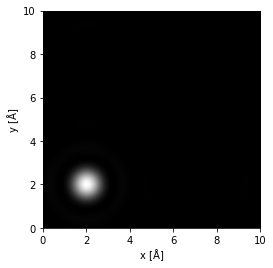

In [15]:
probes = S.collapse(positions=[(2,2),(5,5)])

probes[0].show()

## STEM simulations with scattering matrices

Here we simulate the exact same image as in part 6 of the walkthrough but now using PRISM. We first import our atoms and create the potential.

In [18]:
atoms = read('data/orthogonal_graphene.cif') 

potential = Potential(atoms, sampling=.03)

Then we create the SMatrix builder.

In [19]:
S_builder = SMatrixBuilder(expansion_cutoff=32, interpolation=1, energy=80e3)

As a shorthand, we can then directly call the `.multislice` method of the builder to build the scattering matrix to match a potential and perform a multislice propagation through it.

In [20]:
S = S_builder.multislice(potential)

We can set imaging parameters after doing the propagation part of the simulation.

In [21]:
S.ctf.semiangle_cutoff = 30
S.ctf.defocus = 50
S.ctf.focal_spread = 60

Finally, we can use the `.scan` method to collapse the scattering matrix at given scan positions and use a detector to acquire an image.

In [22]:
detector = AnnularDetector(inner=86, outer=190)

gridscan = GridScan(start=[0, 0], end=[np.sqrt(3) * 1.42, 3 * 1.42], sampling=.2)

measurements = S.scan(gridscan, [detector])

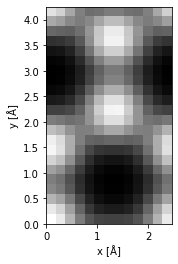

In [23]:
measurements[detector].show();

## The interpolation factor

To be filled in soon.

## Using PRISM with memory-constraints

To be filled in soon.